# Law, Bias, and Algorithms
## Algorithmic fairness (2/2)

Today, we will continue building and evaluating our own risk assessment tool using the COMPAS data to examine some other aspects of fairness.

To recap from last week, let's start by loading the data and refitting the model:

In [3]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Because huge plots are ugly
options(repr.plot.width = 6, repr.plot.height = 4)

# Read the data
compas_df <- read_rds("../data/compas.rds")

# Recap the model
recid_model <- glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        risk_bin = round(risk * 10),
        binary_recid = risk >= 0.5
    )

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.3.2
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## COMPAS data revisited

Recall that the cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher score correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise.

and after fitting our model, we have added the following columns

* `risk`: the model-predicted probability of recidivism
* `predicted_risk_score`: a integer risk score between 0 and 10
* `pred_recid`: a binary prediction of whether each defendant will recidivate

In [4]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid,risk,risk_bin,binary_recid
3,Male,1982-01-22,34,African-American,3,1,0,1,1,0.365,4,FALSE
4,Male,1991-05-14,24,African-American,4,3,4,1,0,0.641,6,TRUE
5,Male,1993-01-21,23,African-American,8,6,1,0,0,0.535,5,TRUE
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0,0.800,8,TRUE
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0,0.311,3,FALSE
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1,0.559,6,TRUE


### Exercise 1: Calibration by gender

Last week we examined how our recidivism prediction model performed for different racial groups, and it turned out our model was well calibrated for white and black defendants.

For this exercise, we will continue examining calibration of our model predictions, but for different genders.

We will reuse the `risk_bin` we calculated last week, which is a discretized (rounded) version of predicted risk probability.

For Exercise 1, calculate recidivism rates for male and female defendants in our dataset by creating a data frame called `calibration_by_gender` containing three columns: `sex`, `risk_bin`, and `recidivism_rate`.
Additionally, to ensure we have enough defendents of each gender in every score bucket, we will limit our maximum score to 8 and remove everyone with score greater than 8.

In [5]:
# Calculate discretized risk score
# group people with risk score equal or gretaer than 8

calibration_by_gender <- compas_df %>%
# WRITE CODE HERE
# START solution
    filter(risk_bin <= 8) %>%
    group_by(sex, risk_bin) %>%
    summarize(
        recidivism_rate = mean(is_recid),
        n = n()
    )
# END solution

# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate) %>%
    group_by(risk_bin) %>%
    summarize(
        n = sum(n),
        Female = first(na.omit(Female)),
        Male = first(na.omit(Male))
    )

risk_bin,n,Female,Male
1,127,0.125,0.158
2,519,0.164,0.237
3,690,0.247,0.309
4,943,0.312,0.395
5,1727,0.363,0.486
6,1025,0.632,0.683
7,505,0.759,0.767
8,329,0.714,0.793


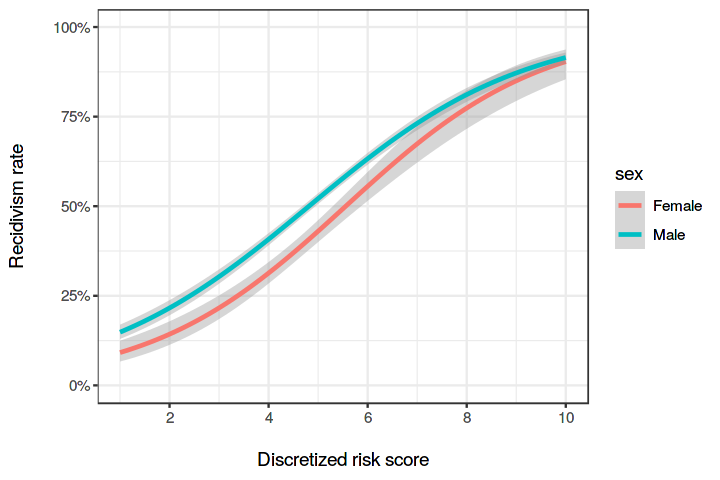

In [7]:
# Calibration plot

ggplot(compas_df, 
       aes(x = risk_bin, y = is_recid, color = sex, group=sex)) + 
    geom_smooth(method="glm", method.args=list(family="binomial")) +
    scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

#### Discussion
Given the plot above, do you think a gender-blind model is "fair"?

### Exercise 2: Re-fit the model by including gender

Note that we observe roughly up to a 1-point difference for male and female risk scores from the plot above.
For example, male defendants who were scored as `4` recidivated at a rate of 40%, while females who recidivated at a similar rate were given a higher score of `5`. 
Because the model is "blind" to gender, women have lower risk compared to their male counterparts who have the same score.

One way to reduce this gender disparity is to explicitly include gender (`sex`) as a variable.
In this exercise, build a gender-aware ricidivism prediction model with `priors_count`, `age`, `sex` and add two columns `gender_specific_risk` and `gender_specific_risk_bin` to the data frame.

In [ ]:
# Refit the model by including gender, look at the coefficients of the fitted model, 
# and generate gender-specific recidivism rate by risk score

# WRITE CODE HERE
# START solution
recid_gender_model <- glm(is_recid ~ priors_count + age + sex, data = compas_df, family = "binomial")

# Show model coeffients
summary(recid_gender_model)

compas_df <- compas_df %>%
    mutate(
        gender_specific_risk = predict(recid_gender_model, type = "response"),
        gender_specific_risk_score = round(gender_specific_risk * 10)
    )

calibration_by_gender <- compas_df %>%
    filter(gender_specific_risk_score <= 8) %>%
    group_by(sex, gender_specific_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))

# END solution

In [ ]:
# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate)

In [ ]:
# Calibration plot
ggplot(compas_df, 
       aes(x = gender_specific_risk_score, y = is_recid, color = sex, group=sex)) + 
    geom_smooth(method="glm", method.args=list(family="binomial")) +
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

### Exercise 3: Compare gender-specific and gender-blind models

Now, let's compare our gender-specific and gender-blind models by examining the number of men and women detained at a detention risk threshold of 50%.

In [ ]:
# Calculate number of men and women detained for gender-specific and gender-blind models

# WRITE CODE HERE
compas_df %>%
# START solution
    mutate(
        detained = risk > 0.5,
        gender_specific_detained = gender_specific_risk > 0.5
    ) %>%
    group_by(sex) %>%
    summarize(
        n_detained = sum(detained),
        n_gender_specific_detained = sum(gender_specific_detained)
    )
# END solution

By including gender in our model, we are able to obtain a calibrated model with fewer number of women detained.
However, by explicitly using gender, we violate anti-classification.
What do you think of this approach?

### Exercise 4: False positive rate and false negative rate

We now introduce _false positive rate (FPR)_ and _false negative rate (FNR)_, two common metrics for evaluating model performance.

Before we talk about their definitions, we define the following terms:

* $N_+$: the number of real positive cases in the data
* $N_-$: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:


| <div></div> | Real positive | Real negative |
|--------------------|---------------|---------------|
| Predicted positive |       TP      |            FP |
| Predicted negative |       FN      |            TN |


Then the false positive rate (FPR) is given by: 

\begin{equation}
  FPR = \frac{FP}{N_-} = \frac{FP}{FP + TN}
\end{equation}

Similarly, the false negative rate (FNR) is given by: 

\begin{equation}
  FNR = \frac{FN}{N_+} = \frac{FN}{TP + FN}
\end{equation}

Coming back to the racial disparity we observed last week, in this exercise, let's calculate our model's FPR and FNR for white and black defendants using a threshold of $50\%$ for our binary prediction (`binary_recid`).

In [8]:
# Complete the function calc_fpr_fnr, which takes a data frame that has at least three columns: race, is_recid and binary_recid,
# and returns a data frame with three columns: race, FPR, and FNR

calc_fpr_fnr <- function(df) {
# WRITE CODE HERE
# START solution
    df %>%
    group_by(race) %>%
    summarize(
        fp = sum((is_recid == 0) & (binary_recid)),
        fn = sum((is_recid == 1) & (!binary_recid)),
        positives = sum(is_recid),
        negatives = sum(!is_recid),
        fpr = fp/negatives,
        fnr = fn/positives
    ) %>%
    select(race, fpr, fnr)
# END solution
}

calc_fpr_fnr(compas_df)

race,fpr,fnr
African-American,0.413,0.240
Caucasian,0.228,0.487


#### Discuss!

### Exercise 5: Equalizing false positive rates

Some have advocated for equalizing FPR to create a "fair" model.
One way to do that is to set different thresholds for white defendants and black defendants.
To do so, we will fix our classification threshold for white defendants at 50% and tune the threshold for black defendants so that the false positive rates are equal for both groups.

Similarly, find the threshold for black defendants that equalizes the false negative rates for both groups.

race,fpr,fnr
African-American,0.413,0.240
Caucasian,0.228,0.487


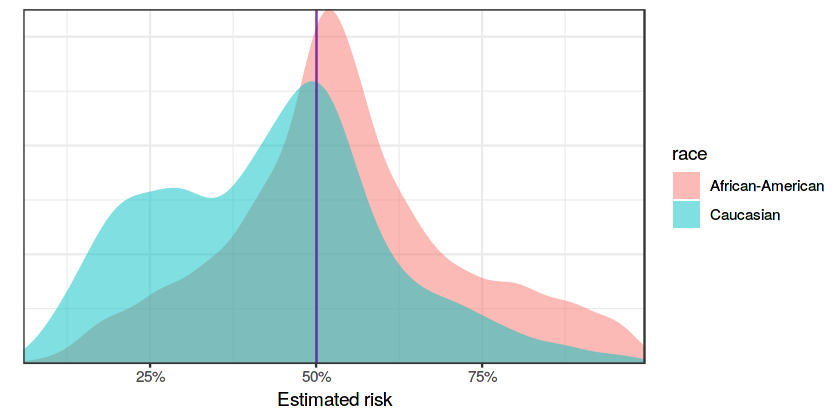

In [10]:
white_threshold = 0.5
black_threshold = 0.5 # WRITE CODE HERE
# START solution
# 0.573 # for equalizing FNR
# 0.555 # for equalizing FPR
# END solution

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(binary_recid = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    calc_fpr_fnr()

# See where the thresholds are on the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)

# Recall this risk distribution plot
# Now we add our thresholds in the plots
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())+
    geom_vline(
        xintercept = c(black_threshold, white_threshold), 
        color = c("red", "blue"),
        alpha = 0.5
    )

#### Discuss.